In [1]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.1 --progress-bar off
!pip install -qqq transformers==4.34.1 --progress-bar off
!pip install -qqq accelerate==0.23.0 --progress-bar off
!pip install -qqq bitsandbytes==0.41.1 --progress-bar off # used for quantization
!pip install -qqq llava-torch==1.1.1 --progress-bar off

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llava-torch 1.1.1 requires torch==2.0.1, but you have torch 2.1.0 which is incompatible.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 2.1.0 which is incompatible.
torchvision 0.15.2+cu118 requires torch==2.0.1, but you have torch 2.1.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llava-torch 1.1.1 requires torch==2.0.1, but you have torch 2.1.0 which is incompatible.
llava-torch 1.1.1 requires transformers==4.31.0, but you have transformers 4.34.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ll

In [2]:
import textwrap
from io import BytesIO

import requests
import torch
from llava.constants import DEFAULT_IMAGE_TOKEN, IMAGE_TOKEN_INDEX
from llava.conversation import SeparatorStyle, conv_templates
from llava.mm_utils import (
    KeywordsStoppingCriteria,
    get_model_name_from_path,
    process_images,
    tokenizer_image_token,
)
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from PIL import Image

[2024-05-16 10:08:59,338] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
disable_torch_init()

In [4]:
MODEL = "liuhaotian/llava-v1.5-13b-lora"
model_name = get_model_name_from_path(MODEL)
print(model_name)

MODEL_BASE = "liuhaotian/llava-v1.6-vicuna-13b"
model_base_name = get_model_name_from_path(MODEL_BASE)
print(model_base_name)

llava-v1.5-13b-lora
llava-v1.6-vicuna-13b


In [5]:
# Cannot merge LORA layers when the model is loaded in 8-bit mode
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=MODEL, model_base=MODEL_BASE, model_name=model_name, load_8bit=False
)

Loading LLaVA from base model...


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Some weights of LlavaLlamaForCausalLM were not initialized from the model checkpoint at liuhaotian/llava-v1.6-vicuna-13b and are newly initialized: ['model.layers.0.self_attn.rotary_emb.inv_freq', 'model.layers.33.self_attn.rotary_emb.inv_freq', 'model.layers.13.self_attn.rotary_emb.inv_freq', 'model.layers.16.self_attn.rotary_emb.inv_freq', 'model.layers.6.self_attn.rotary_emb.inv_freq', 'model.layers.23.self_attn.rotary_emb.inv_freq', 'model.layers.28.self_attn.rotary_emb.inv_freq', 'model.layers.38.self_attn.rotary_emb.inv_freq', 'model.layers.24.self_attn.rotary_emb.inv_freq', 'model.layers.12.self_attn.rotary_emb.inv_freq', 'model.layers.30.self_attn.rotary_emb.inv_freq', 'model.layers.3.self_attn.rotary_emb.inv_freq', 'model.layers.32.self_attn.rotary_emb.inv_freq', 'model.layers.25.self_attn.rotary_emb.inv_freq', 'model.layers.18.self_attn.rotary_emb.inv_freq', 'model.layers.39.self_attn.rotary_emb.inv_freq', 'model.layers.31.self_attn.rotary_emb.inv_freq', 'model.layers.37.self

Loading additional LLaVA weights...
Loading LoRA weights...
Merging LoRA weights...
Model is loaded...


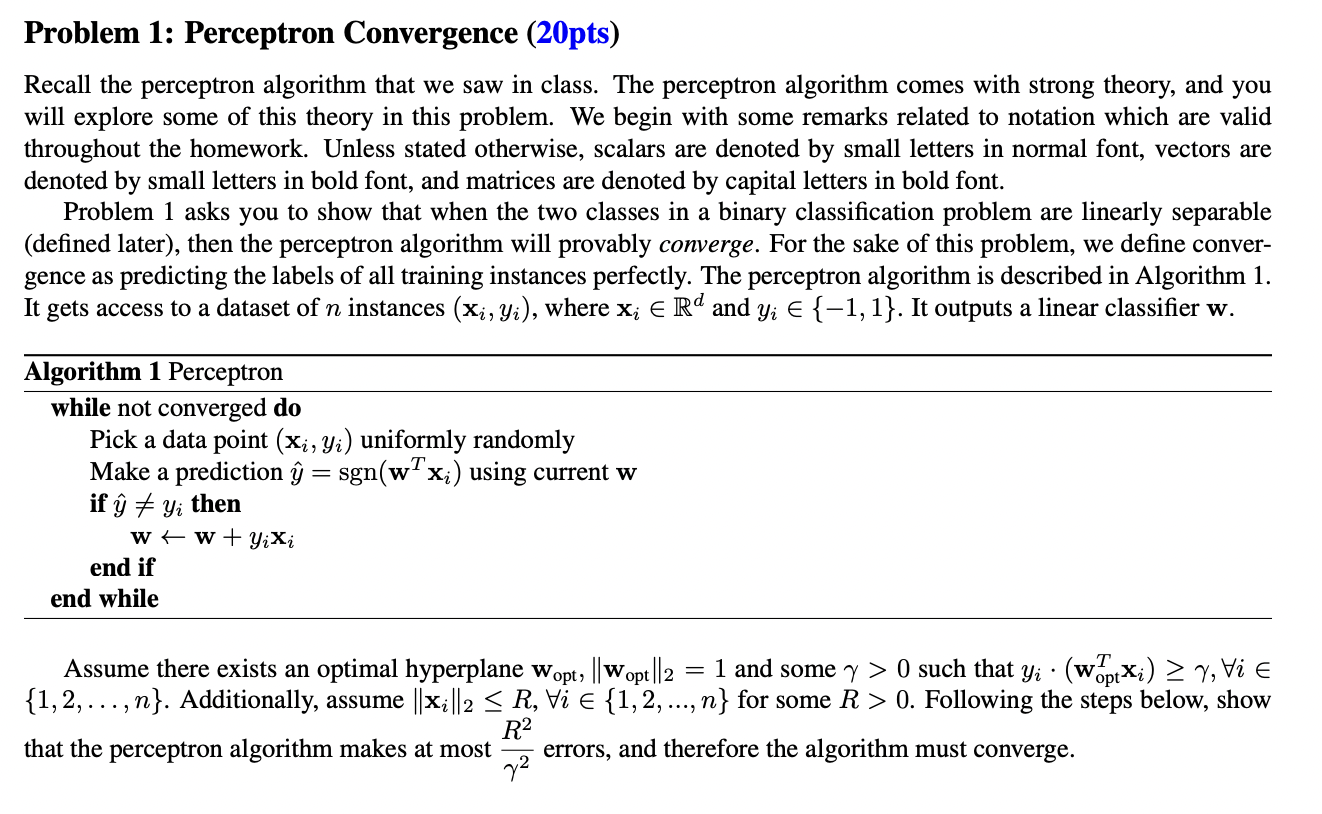

In [6]:
import io

with open('hw1.png', "rb") as image_file:
    f = image_file.read()
    b = bytearray(f)

image = Image.open(io.BytesIO(b))
image.show()

In [7]:
def process_image(image):
    args = {"image_aspect_ratio": "pad"}
    image_tensor = process_images([image], image_processor, args)
    return image_tensor.to(model.device, dtype=torch.float16)

In [8]:
processed_image = process_image(image)
type(processed_image), processed_image.shape

(torch.Tensor, torch.Size([1, 3, 336, 336]))

In [9]:
CONV_MODE = "llava_v0"

In [10]:
def create_prompt(prompt: str):
    conv = conv_templates[CONV_MODE].copy()
    roles = conv.roles
    prompt = DEFAULT_IMAGE_TOKEN + "\n" + prompt
    conv.append_message(roles[0], prompt)
    conv.append_message(roles[1], None)
    return conv.get_prompt(), conv

In [11]:
prompt, _ = create_prompt("Write down what is written in the image and explain it")
print(prompt)
     

A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions.###Human: <image>
Write down what is written in the image and explain it###Assistant:


In [12]:
def ask_image(image: Image, prompt: str):
    image_tensor = process_image(image)
    prompt, conv = create_prompt(prompt)
    input_ids = (
        tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
        .unsqueeze(0)
        .to(model.device)
    )

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    stopping_criteria = KeywordsStoppingCriteria(
        keywords=[stop_str], tokenizer=tokenizer, input_ids=input_ids
    )

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=image_tensor,
            do_sample=True,
            temperature=0.01,
            max_new_tokens=512,
            use_cache=True,
            stopping_criteria=[stopping_criteria],
        )
    return tokenizer.decode(
        output_ids[0, input_ids.shape[1] :], skip_special_tokens=True
    ).strip()

In [13]:
%%time
result = ask_image(image, "I want the text written in the image line by line")
print(textwrap.fill(result, width=110))

Sure, here is the text from the image:  "Perceptron Convergence Algorithm  The perceptron algorithm is a
supervised learning algorithm used primarily for classification problems. It is a simple linear classifier
that works by iteratively adjusting the weights of the neurons in the network to minimize the error between
the predicted output and the actual output.  The perceptron algorithm is an optimization algorithm that seeks
to find the optimal values of the weights for the neurons in the network. It does this by adjusting the
weights in a way that minimizes the error between the predicted output and the actual output.  The perceptron
algorithm is a binary classification algorithm, meaning that it can only classify data into two categories. It
works by iteratively adjusting the weights of the neurons in the network until the output of the network
converges to the correct category.  The perceptron algorithm is a linear classifier, meaning that it uses a
linear decision boundary to sepa

In [14]:
%%time
result = ask_image(image, "Write down the algorithm given in the image")
print(textwrap.fill(result, width=110))

The image shows a snippet of code from a Python script, which is part of a neural network training process.
The code is related to the perceptron algorithm, which is a type of artificial neural network. Here is the
algorithm as seen in the image:  ```python # Perceptron Convergence (20pts)  # The perceptron algorithm comes
with some theory in class notes. # We begin with some remarks related to the theory.  # The perceptron
algorithm is a binary classification problem. # It is described by the following equation: #   w_t = w_{t-1} +
x_t * (y_t - w_{t-1} * x_{t-1}) #   where w_t is the weight vector at time t, and x_t is the input vector at
time t. #   y_t is the output at time t, and w_{t-1} is the weight vector at time t-1.  # The perceptron
algorithm is described by the following equation: #   w_t = w_{t-1} + x_t * (y_t - w_{t-1} * x_{t-1}) #
where w_t is the weight vector at time t, and x_t is the input vector at time t. #   y_t is the output at time
t, and w_{t-1} is the weight vec

In [15]:
result = ask_image(image, "Write down the algorithm given in the image, also write the python function for the algorithm")
print(textwrap.fill(result, width=110))

The image shows a mathematical algorithm for a perceptron classifier, which is a type of artificial neural
network used for binary classification. The algorithm is written in pseudo-code, which is a high-level, human-
readable representation of an algorithm that can be translated into a programming language.  Here is the
algorithm in pseudo-code:  ``` Perceptron Algorithm  initialize:     w = 0     b = 0  for each training
example (x, y) in the dataset:     for each feature (x_i) in the example:         if x_i > 0:             w =
w + y * x_i         else:             w = w - y * x_i      if sign(w) != y:         b = b + 1  if b == 0:
output = 0 else:     output = 1 ```  To convert this pseudo-code into a Python function, you would first need
to define the necessary variables and functions. Here is an example of how you might implement this algorithm
in Python:  ``` import numpy as np  def perceptron_algorithm(dataset):     # Initialize the weights and bias
w = 0     b = 0      # Itera

In [17]:
result.text

AttributeError: 'str' object has no attribute 'text'